In [1]:
import pandas as pd
# coding: UTF-8
import time
import torch
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from torch.utils.data import SubsetRandomSampler
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from units import *
import pyreadstat

### 数据预处理

In [2]:
save='./统计指标3/1/'
df, meta = pyreadstat.read_sav('./data/调整后数据.sav')
rawdata=df[['collect_count', 'create_time', 'digg_count', 'duration',
       'follower_count', 'gender', 'share_count', 'comment_count',
       'comment_get', '意向']]
# rawdata=rawdata[['aweme_id','collect_count','create_time','digg_count','duration','follower_count','gender','share_count','keyword','comment_get','comment_count','intention_counts','variation','arousal']]
# rawdata=rawdata[rawdata['variation'].notna()]
# rawdata=rawdata[rawdata['arousal'].notna()]
# rawdata['keyword']=rawdata['keyword'].apply(keyword_encode) # 非数字编码
# rawdata.fillna(0) # 空值填充0
# rawdata['intention_counts']=rawdata['intention_counts']/rawdata['comment_get']
# rawdata.drop('comment_get',axis=1)
rawdata.columns=['collect_count', 'create_time', 'digg_count', 'duration',
       'follower_count', 'gender', 'share_count', 'comment_count',
       'comment_get', 'intention']
rawdata

,collect_count,create_time,digg_count,duration,follower_count,gender,share_count,comment_count,comment_get,intention
0,354.0,1.536720e+09,171914.0,59000.0,1375225.0,1.0,2250.0,2494.0,40.0,9.0
1,6463.0,1.551005e+09,551236.0,52234.0,4568793.0,2.0,36969.0,10767.0,20.0,6.0
2,4196.0,1.551282e+09,164671.0,15000.0,588090.0,1.0,13965.0,3153.0,40.0,11.0
3,154.0,1.551913e+09,31207.0,42121.0,1030347.0,2.0,286.0,391.0,20.0,2.0
4,9427.0,1.554560e+09,545115.0,40239.0,588104.0,1.0,24688.0,9003.0,39.0,5.0
...,...,...,...,...,...,...,...,...,...,...
3517,70.0,1.673417e+09,466.0,40402.0,20661.0,0.0,39.0,481.0,40.0,13.0
3518,359.0,1.673593e+09,935.0,60256.0,5662.0,0.0,51.0,71.0,33.0,11.0
3519,52.0,1.673602e+09,988.0,58300.0,33626.0,0.0,16.0,87.0,14.0,1.0
3520,19.0,1.673618e+09,566.0,16742.0,2789.0,0.0,399.0,71.0,37.0,4.0


### 数据归一化

In [3]:
scaler = MinMaxScaler() #实例化
data = scaler.fit_transform(rawdata) #fit，在这里本质是生成min(x)和max(x)

### 划分数据集

In [4]:
                                 
X_train, X_test, y_train, y_test = train_test_split(data[:,:-1], data[:,-1], test_size=0.20,random_state=12)
model = XGBRegressor()
model.fit(X_train,y_train)
scores = model.score(X_test,y_test)
print(scores)           
y_pred=model.predict(X_test)                              

0.2603730228763156


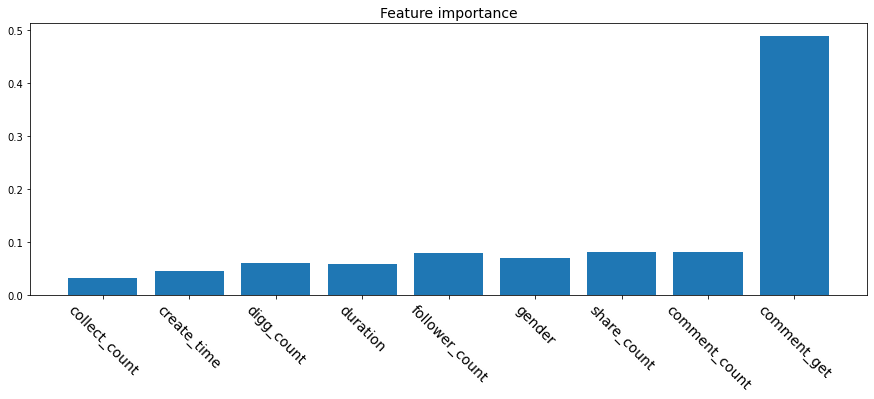

In [5]:
# 获取feature importance
import matplotlib.pyplot as plt
cols=rawdata.iloc[:,:-1].columns
plt.figure(figsize=(15, 5))
plt.bar(range(len(cols)), model.feature_importances_)
pd.DataFrame()
plt.xticks(range(len(cols)), cols, rotation=-45, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.savefig(save+'feature_importance.png')
plt.show()

In [6]:
imp=pd.DataFrame(model.feature_importances_,index=cols).T
imp

,collect_count,create_time,digg_count,duration,follower_count,gender,share_count,comment_count,comment_get
0,0.033139,0.044769,0.061104,0.057921,0.079893,0.07092,0.081225,0.082193,0.488838


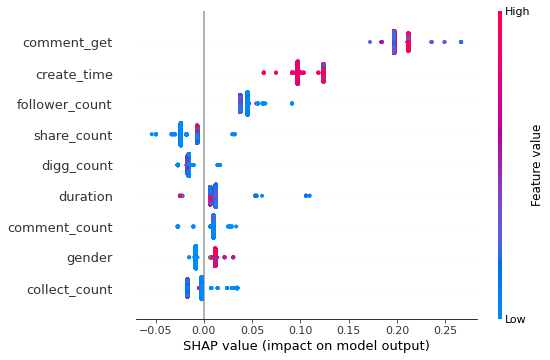

In [7]:
import shap
plt.figure(figsize=(6, 5))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(rawdata.iloc[:,:-1][cols])
y_base = explainer.expected_value 
shap.summary_plot(shap_values, rawdata.iloc[:,:-1][cols],show=False)
plt.savefig(save+'shap.png')

In [8]:
j = len(imp)
player_explainer = pd.DataFrame()
player_explainer['feature'] = cols
player_explainer['shap_value'] = shap_values[j]
player_explainer


,feature,shap_value
0,collect_count,-0.017153
1,create_time,0.123981
2,digg_count,-0.016965
3,duration,0.006673
4,follower_count,0.037770
5,gender,0.011772
6,share_count,-0.006946
7,comment_count,0.009751
8,comment_get,0.211895


In [9]:
player_explainer['XGB_importance']=imp.iloc[0].values
player_explainer.to_csv(save+'import_tabel.csv',index=False,encoding='utf_8_sig')
player_explainer

,feature,shap_value,XGB_importance
0,collect_count,-0.017153,0.033139
1,create_time,0.123981,0.044769
2,digg_count,-0.016965,0.061104
3,duration,0.006673,0.057921
4,follower_count,0.037770,0.079893
5,gender,0.011772,0.070920
6,share_count,-0.006946,0.081225
7,comment_count,0.009751,0.082193
8,comment_get,0.211895,0.488838


In [10]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

y_true = y_test

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
evs = explained_variance_score(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'EVS': evs, 'R2': r2}

df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
df.to_csv(save+'Metric.csv',index=False,encoding='utf_8_sig')
print(df)

  Metric     Value
0    MAE  0.092471
1    MSE  0.015425
2   RMSE  0.124197
3    EVS  0.260460
4     R2  0.260373
